In [1]:
import numpy as np
from lmfit.models import ExponentialModel, LinearModel
from lmfit import Model, Parameters
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import derivative
avogadro_constant = avogadro_constant = 6.022e23


def convert_to_concentration(df,liter):
    for column in range(1,df.shape[1]):
        #print(column)
        df.iloc[:,column] = ((df.iloc[:,column]/avogadro_constant)/liter)
    return df


data_raw = pd.read_csv('concentration_data_1.5k.csv',sep=',')
name = 'a'
name_2 = 'b'

In [2]:
def fit_concentration_plot(df,name,sup_lim=-1):
    x_data = df.iloc[0:sup_lim,0].values

    y1_data = df.iloc[0:sup_lim,1].values #Cl
    y2_data = df.iloc[0:sup_lim,2].values #Na
    #print(len(y1_data),len(y2_data))

    modelo_exponencial_1 = ExponentialModel(prefix = 'exp_1_')
    modelo_exponencial_2 = ExponentialModel(prefix = 'exp_2_')
    print(f'Variável independente_1: {modelo_exponencial_1.independent_vars}')
    print(f'Parâmetros modelo_1: {modelo_exponencial_1.param_names}')
    print()
    print(f'Variável independente_2: {modelo_exponencial_2.independent_vars}')
    print(f'Parâmetros modelo_2: {modelo_exponencial_2.param_names}')

    params_exponencial_1 = modelo_exponencial_1.guess(y1_data,x=x_data)
    params_exponencial_2 = modelo_exponencial_2.guess(y2_data,x=x_data)
    params_exponencial_1.pretty_print()
    print()
    params_exponencial_2.pretty_print()

    resultado_fit_1 = modelo_exponencial_1.fit(y1_data, params_exponencial_1, x=x_data)
    resultado_fit_2 = modelo_exponencial_2.fit(y2_data, params_exponencial_2, x=x_data)
    print(resultado_fit_1.fit_report())
    print()
    print(resultado_fit_2.fit_report())

    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    ax.plot(x_data, y1_data, label="Data Cl")
    ax.plot(x_data, y2_data, label="Data Na")
    ax.plot(x_data, resultado_fit_1.best_fit, label="Fit Cl")
    ax.plot(x_data, resultado_fit_2.best_fit, label="Fit Na")
    plt.title('Fit Concentração x Tempo')
    plt.xlabel('Tempo')
    plt.ylabel('Concentração')
    plt.legend()
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()

    data_vel_fit = {'x_data' : x_data,'resultado_fit_1' : resultado_fit_1, 'resultado_fit_2' : resultado_fit_2, 'y1_data' : y1_data, 'y2_data' : y2_data}

    return data_vel_fit


Variável independente_1: ['x']
Parâmetros modelo_1: ['exp_1_amplitude', 'exp_1_decay']

Variável independente_2: ['x']
Parâmetros modelo_2: ['exp_2_amplitude', 'exp_2_decay']
Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
exp_1_amplitude     155.7     -inf      inf     None     True     None     None
exp_1_decay         104.9     -inf      inf     None     True     None     None

Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
exp_2_amplitude     161.6     -inf      inf     None     True     None     None
exp_2_decay           173     -inf      inf     None     True     None     None
[[Model]]
    Model(exponential, prefix='exp_1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 20028
    # variables        = 2
    chi-square         = 16152668.5
    reduced chi-square = 806.584863
    Akaike info crit   = 134045.581
    Bayesian info crit = 134061.391
    R-sq

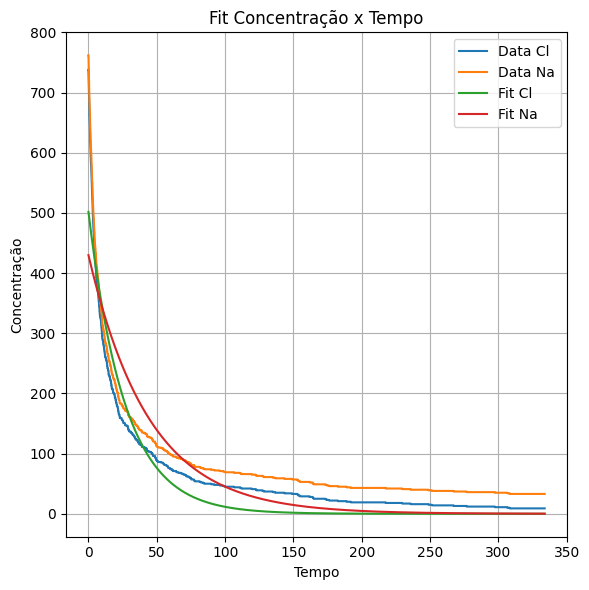

In [3]:
data_vel_fit = fit_concentration_plot(data_raw, name=name,sup_lim=20028)

In [9]:

def rate_plot_2(data_vel_fit,name):
    print(data_vel_fit['resultado_fit_1'])
    print(data_vel_fit['resultado_fit_1'].best_fit)
    derivative = -np.diff(data_vel_fit['resultado_fit_1'].best_fit,n=1)
    print(derivative)
    concentrations = data_vel_fit['y1_data'][:-1]


    model = LinearModel()

    # Create a Parameters object to store the parameter values
    params_linear = model.guess(derivative, x=concentrations)

    # Perform the fit
    result_linear = model.fit(derivative, params_linear, x=concentrations)

    slope_linear = result_linear.params['slope'].value
    intercept_linear = result_linear.params['intercept'].value


    fig2, ax2 = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    #ax2.plot(data_vel_fit['y1_data'], derivative_1, label = "Velocidade em Cl")
    ax2.plot(concentrations,derivative, label = "Cl")
    ax2.plot(concentrations, result_linear.best_fit, label=f"Coeficiente K: {slope_linear}", color='red')

    plt.title('Fit d[Concentração]/dt x Concentração')
    plt.xlabel('Concentração')
    plt.ylabel('d[Concentração]/dt')
    plt.legend()
    plt.grid(True)
    fig2.tight_layout()
    fig2.savefig(name_2)  # Salva a figura
    plt.show()

[5.01688576e+02 5.01373446e+02 5.01058513e+02 ... 1.72163718e-03
 1.72055575e-03 1.71947500e-03]
[3.15130749e-01 3.14932803e-01 3.14734981e-01 ... 1.08210919e-06
 1.08142948e-06 1.08075019e-06]


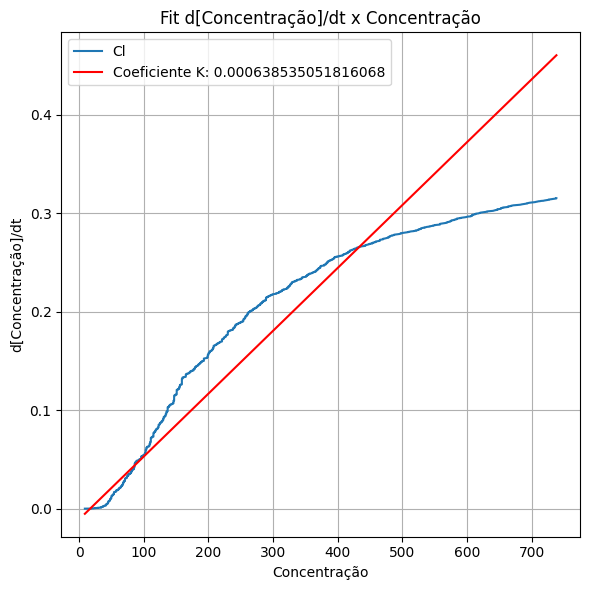

In [10]:
rate_plot_2(data_vel_fit,name)

In [6]:
from lmfit import Model, Parameters
from lmfit.models import LinearModel


def vel_rate_plot_tst(data_vel_fit, name_2):
    #calcular as derivadas do fit manualmente; f(x) = A * exp´(B * x) -> f'(x) = A * B * exp(B * x)
    derivative_1 = data_vel_fit['resultado_fit_1'].best_fit * data_vel_fit['resultado_fit_1'].params['exp_1_amplitude']
    derivative_2 = data_vel_fit['resultado_fit_2'].best_fit * data_vel_fit['resultado_fit_2'].params['exp_2_amplitude']

    def rate_equation(x, k):
        return k * data_vel_fit['y1_data'] * data_vel_fit['y2_data']

    model = LinearModel()

    # Create a Parameters object to store the parameter values
    params = model.guess(derivative_1, x=data_vel_fit['y1_data'])

    # Perform the fit
    result = model.fit(derivative_1, params, x=data_vel_fit['y1_data'])

    # Access the fit results
    print(result.fit_report())

    fig2, ax2 = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    #ax2.plot(data_vel_fit['y1_data'], derivative_1, label = "Velocidade em Cl")
    ax2.plot(data_vel_fit['x_data'], 1/data_vel_fit['y1_data'], label = "Velocidade em Cl")
    #ax2.plot(data_vel_fit['y2_data'], derivative_2, label = "Velocidade em Na")
    ax2.plot(data_vel_fit['y1_data'], result.best_fit, 'r-', label=f'Best Fit')
    plt.title('Fit Velocidade x Concentração')
    plt.xlabel('Concentração')
    plt.ylabel('Velocidade da reação')
    plt.legend()
    plt.grid(True)
    fig2.tight_layout()
    fig2.savefig(name_2)  # Salva a figura
    plt.show()


In [7]:
def rate_plot_3(df,name):
    concentracao = df.iloc[:,1][0:28398]/avogadro_constant/1
    tempo = df.iloc[:,0][0:28398]

    fig2, ax2 = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    #ax2.plot(data_vel_fit['y1_data'], derivative_1, label = "Velocidade em Cl")
    ax2.plot(tempo,1/concentracao, label = "Velocidade em Cl")

    plt.title('Fit Velocidade x Concentração')
    plt.xlabel('Concentração')
    plt.ylabel('Velocidade da reação')
    plt.legend()
    plt.grid(True)
    fig2.tight_layout()
    fig2.savefig(name_2)  # Salva a figura
    plt.show()

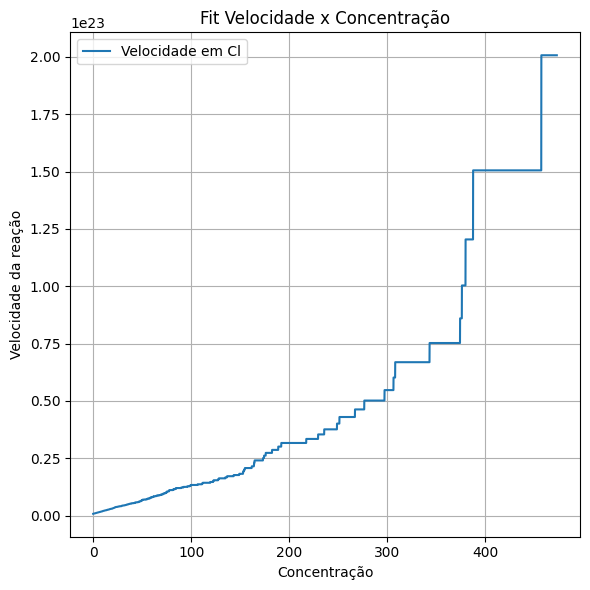

In [8]:
rate_plot_3(data_raw,name)

In [5]:
def rate_plot_4(data_vel_fit,name):
    print(data_vel_fit['resultado_fit_1'])
    print(data_vel_fit['resultado_fit_1'].best_fit)
    derivative = -np.diff(data_vel_fit['resultado_fit_1'].best_fit,n=1)
    print(derivative)
    concentrations = data_vel_fit['y1_data'][:-1]


    # Define the quadratic model function
    def quadratic_model(x, a, b, c):
        return a * x**2 + b * x + c
        
    mod = Model(quadratic_model)

# Automatically guess initial parameter values
    params_quadratic = Parameters()
    params_quadratic.add('a', value=1.0)
    params_quadratic.add('b', value=1.0)
    params_quadratic.add('c', value=1.0)

    # Perform the fit
    result_quadratic = mod.fit(derivative, params_quadratic, x=concentrations)

    # Print and visualize the fit results
    print(result_quadratic.fit_report())
    a_value = result_quadratic.params['a'].value
    b_value = result_quadratic.params['b'].value
    c_value = result_quadratic.params['c'].value

    fig2, ax2 = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    #ax2.plot(data_vel_fit['y1_data'], derivative_1, label = "Velocidade em Cl")
    ax2.plot(concentrations,derivative, label = "Concentração de Cl")
    ax2.plot(concentrations, result_quadratic.best_fit, label=f"Coeficiente K: {a_value}", color='red')

    plt.title('Fit d[Concentração]/dt x Concentração')
    plt.xlabel('Concentração')
    plt.ylabel('Velocidade')
    plt.legend()
    plt.grid(True)
    fig2.tight_layout()
    fig2.savefig(name_2)  # Salva a figura
    plt.show()

[5.01688576e+02 5.01373446e+02 5.01058513e+02 ... 1.72163718e-03
 1.72055575e-03 1.71947500e-03]
[3.15130749e-01 3.14932803e-01 3.14734981e-01 ... 1.08210919e-06
 1.08142948e-06 1.08075019e-06]
[[Model]]
    Model(quadratic_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 20027
    # variables        = 3
    chi-square         = 1.96354177
    reduced chi-square = 9.8059e-05
    Akaike info crit   = -184844.948
    Bayesian info crit = -184821.233
    R-squared          = 0.97047575
[[Variables]]
    a: -6.0098e-07 +/- 3.9828e-09 (0.66%) (init = 1)
    b:  9.1323e-04 +/- 1.9889e-06 (0.22%) (init = 1)
    c: -0.01997117 +/- 1.0244e-04 (0.51%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.9153
    C(b, c) = -0.7105
    C(a, c) = +0.5821


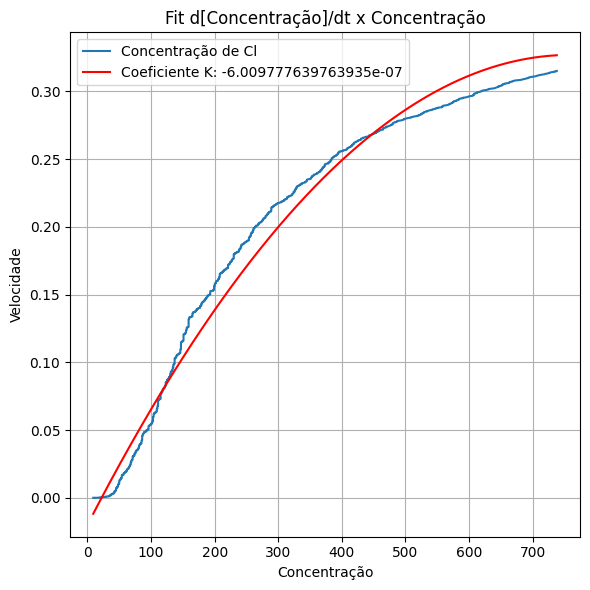

In [6]:
rate_plot_4(data_vel_fit,name)